In [63]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import keras
import tensorflow as tf
from keras.applications.resnet import ResNet50
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D, Activation, Input, pooling

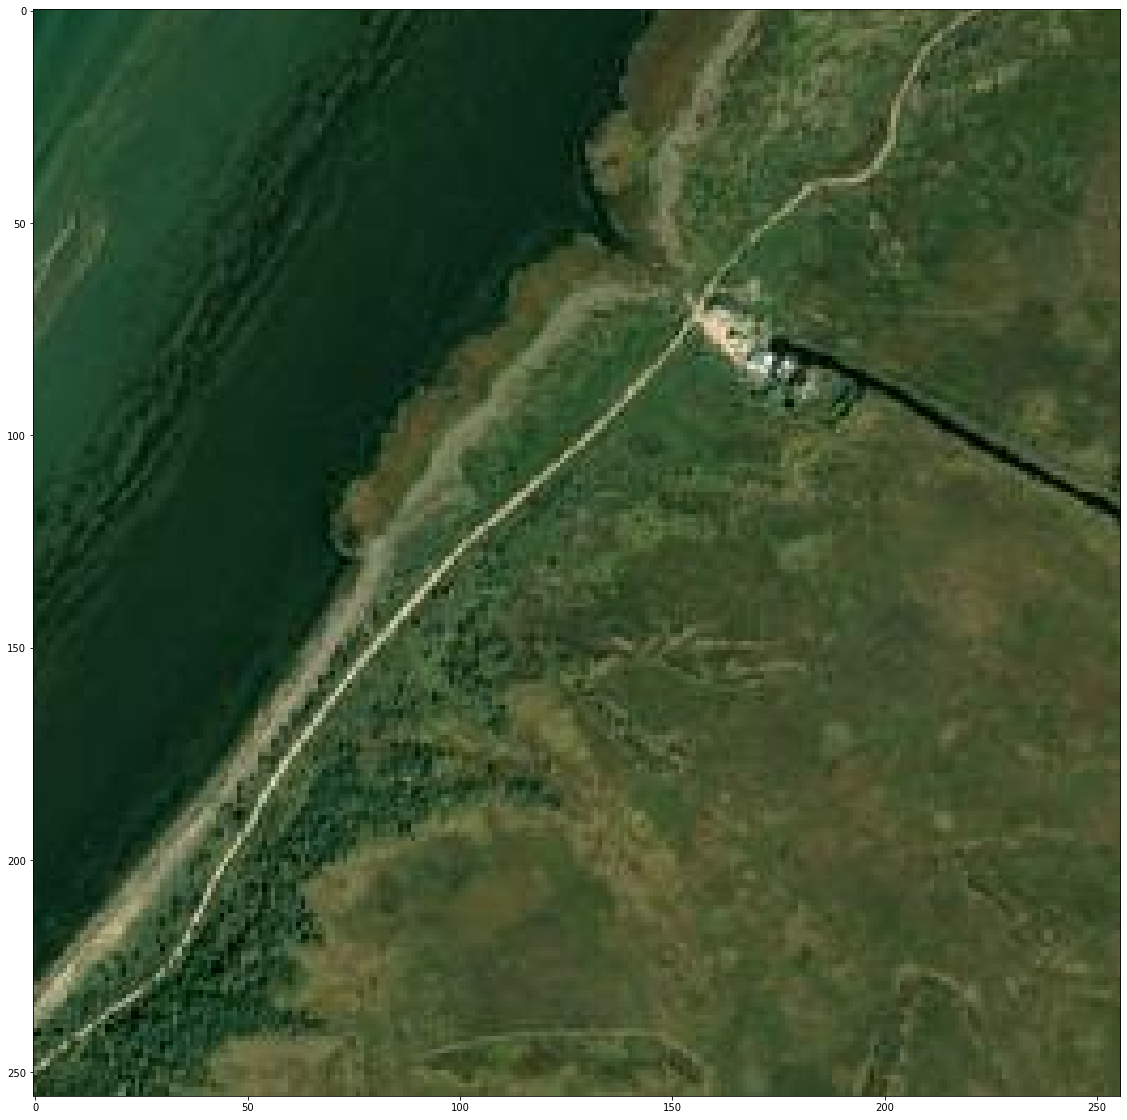

In [64]:
seg_png = cv2.imread(r".\images\1.png")
plt.figure(figsize=(20,20))
plt.imshow(seg_png[...,[2,1,0]])
plt.show()

In [65]:
#входной слой, делаем первый блок, где у нас будет 2 свертки и 1 пуллинг, который уменьшит размерность в 2 раза(примерно)
inp = Input(shape=(256,256,3))


# Первый блок
# 2 свертки
                                    #32 - число фильтров | размер кернала 3 на 3, чтобы учитывать взаимодействия между соседними пикселями
                                    # padding, чтобы получить размерность такая же какая и была
first_convolution_first_block = Conv2D(32,(3, 3),padding='same')(inp)
first_convolution_first_block = Activation('relu')(first_convolution_first_block) #средний слой, необязательно находить вероятность на этом слое
second_convolution_first_block = Conv2D(32,(3, 3),padding='same')(first_convolution_first_block)
second_convolution_first_block = Activation('relu')(second_convolution_first_block)

# пуллинг
pooling_first_block = MaxPooling2D(2)(second_convolution_first_block)

# Второй блок

first_convolution_second_block = Conv2D(64,(3, 3),padding='same')(pooling_first_block)
first_convolution_second_block = Activation('relu')(first_convolution_second_block)
second_convolution_second_block = Conv2D(64,(3, 3),padding='same')(first_convolution_second_block)
second_convolution_second_block = Activation('relu')(second_convolution_second_block)
pooling_second_block = MaxPooling2D(2)(second_convolution_second_block)

# Третий блок

first_convolution_third_block = Conv2D(128,(3, 3),padding='same')(pooling_second_block)
first_convolution_third_block = Activation('relu')(first_convolution_third_block)
second_convolution_third_block = Conv2D(128,(3, 3),padding='same')(first_convolution_third_block)
second_convolution_third_block = Activation('relu')(second_convolution_third_block)
pooling_third_block = MaxPooling2D(2)(second_convolution_third_block)

# Четвертый блок

first_convolution_fourth_block = Conv2D(256,(3, 3),padding='same')(pooling_third_block)
first_convolution_fourth_block = Activation('relu')(first_convolution_fourth_block)
second_convolution_fourth_block = Conv2D(256,(3, 3),padding='same')(first_convolution_fourth_block)
second_convolution_fourth_block = Activation('relu')(second_convolution_fourth_block)
pooling_fourth_block = MaxPooling2D(2)(second_convolution_fourth_block)

# Пятый блок

first_convolution_fifth_block = Conv2D(512,(3, 3),padding='same')(pooling_fourth_block)
first_convolution_fifth_block = Activation('relu')(first_convolution_fifth_block)
second_convolution_fifth_block = Conv2D(512,(3, 3),padding='same')(first_convolution_fifth_block)
second_convolution_fifth_block = Activation('relu')(second_convolution_fifth_block)
pooling_fifth_block = MaxPooling2D(2)(second_convolution_fifth_block)

# апсемплинг слои, увеличим разрешение

first_upsampling = UpSampling2D(2, interpolation='bilinear')(pooling_fifth_block)

first_convolution_first_block_upsampling = Conv2D(512,(3, 3),padding='same')(first_upsampling)
first_convolution_first_block_upsampling = Activation('relu')(first_convolution_first_block_upsampling)
second_convolution_first_block_upsampling = Conv2D(512,(3, 3),padding='same')(first_convolution_first_block_upsampling)
second_convolution_first_block_upsampling = Activation('relu')(second_convolution_first_block_upsampling)
# второй
second_upsampling = UpSampling2D(2, interpolation='bilinear')(second_convolution_first_block_upsampling)
first_convolution_second_block_upsampling = Conv2D(256,(3, 3),padding='same')(second_upsampling)
first_convolution_second_block_upsampling = Activation('relu')(first_convolution_second_block_upsampling)
second_convolution_second_block_upsampling = Conv2D(256,(3, 3),padding='same')(first_convolution_second_block_upsampling)
second_convolution_second_block_upsampling = Activation('relu')(second_convolution_second_block_upsampling)
# третий
third_upsampling = UpSampling2D(2, interpolation='bilinear')(second_convolution_second_block_upsampling)
first_convolution_third_block_upsampling = Conv2D(128,(3, 3),padding='same')(third_upsampling)
first_convolution_third_block_upsampling = Activation('relu')(first_convolution_third_block_upsampling)
second_convolution_third_block_upsampling = Conv2D(128,(3, 3),padding='same')(first_convolution_third_block_upsampling)
second_convolution_third_block_upsampling = Activation('relu')(second_convolution_third_block_upsampling)
# четвертый 
fourth_upsampling = UpSampling2D(2, interpolation='bilinear')(second_convolution_third_block_upsampling)
first_convolution_fourth_block_upsampling = Conv2D(64,(3, 3),padding='same')(fourth_upsampling)
first_convolution_fourth_block_upsampling = Activation('relu')(first_convolution_fourth_block_upsampling)
second_convolution_fourth_block_upsampling = Conv2D(64,(3, 3),padding='same')(first_convolution_fourth_block_upsampling)
second_convolution_fourth_block_upsampling = Activation('relu')(second_convolution_fourth_block_upsampling)
# пятый
fifth_upsampling = UpSampling2D(2, interpolation='bilinear')(second_convolution_fourth_block_upsampling)
first_convolution_fifth_block_upsampling = Conv2D(32,(3, 3),padding='same')(fifth_upsampling)
first_convolution_fifth_block_upsampling = Activation('relu')(first_convolution_fifth_block_upsampling)
second_convolution_fifth_block_upsampling = Conv2D(1,(3, 3),padding='same')(first_convolution_fifth_block_upsampling)

result = Activation('sigmoid')(second_convolution_fifth_block_upsampling)
model = Model(inputs=inp, outputs=result)

In [66]:
model

In [75]:
best_w = keras.callbacks.ModelCheckpoint('segnet_best.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=True,
                                mode='auto',
                                period=1)

last_w = keras.callbacks.ModelCheckpoint('segnet_last.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=True,
                                mode='auto',
                                period=1)


callbacks = [best_w, last_w]



adam = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)


model.compile(adam, 'binary_crossentropy')

C:\Users\miham\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [82]:
df = pd.read_csv('jp_images.csv')
df.shape

(6, 2)

In [83]:
train_df = df[:4000]
val_df = df[4000:]

In [84]:
def rle_decode(mask_rle, shape=(1280, 1918, 1)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
        
    img = img.reshape(shape)
    return img


In [91]:
def keras_generator(gen_df, batch_size):
    while True:
        x_batch = []
        y_batch = []
        
        for i in range(batch_size):
            img_name, mask_rle = gen_df.sample(1).values[0]
            img = cv2.imread('r.\images\1.png{}'.format(img_name))
            mask = rle_decode(mask_rle)
            
            img = cv2.resize(img, (256, 256))
            mask = cv2.resize(mask, (256, 256))
            
            
            x_batch += [img]
            y_batch += [mask]

        x_batch = np.array(x_batch) / 255.
        y_batch = np.array(y_batch)

        yield x_batch, np.expand_dims(y_batch, -1)

In [92]:
batch_size = 16
model.fit_generator(keras_generator(train_df, batch_size),
              steps_per_epoch=100,
              epochs=15,
              verbose=1,
              callbacks=callbacks,
              validation_data=keras_generator(val_df, batch_size),
              validation_steps=50,
              class_weight=None,
              max_queue_size=10,
              workers=1,
              use_multiprocessing=False,
              shuffle=True,
              initial_epoch=0)

C:\Users\miham\AppData\Local\Temp\ipykernel_15544\3255308999.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(keras_generator(train_df, batch_size),


ValueError: invalid literal for int() with base 10: '.\\images\\1.png'